In [14]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.node_parser import SimpleNodeParser
from config import DOCUMENT_PATH, EMBEDDING_MODEL_NAME, EMBEDDING_MODEL_PATH, TOP_K
from llm_loader import load_llm
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.memory import ChatMemoryBuffer

from llama_index.core import PromptTemplate
from llama_index.core.chat_engine import CondenseQuestionChatEngine
from llama_index.core.llms import ChatMessage, MessageRole

import chromadb
from llama_index.core import StorageContext, VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore

import time 
from llama_index.core.evaluation import BatchEvalRunner, RetrieverEvaluator, QueryResponseEvaluator
import json

from tqdm import tqdm
import pandas as pd
import numpy as np
from typing import List, Dict
import seaborn as sns
import matplotlib.pyplot as plt
from helper import check_collection_exist
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
### to Load the Earlier Llamaindex reference dataset
### Rag_dataset contains the queries and the corresponding answers

# Load the JSON data from the file
with open("./data/rag_dataset.json", "r") as f:
    dataset_data = json.load(f)

# Create a helper class that gives attribute access to the queries
class RagDataset:
    def __init__(self, data):
        self.data = data
        self.examples = self.data.get("examples", [])
    
    @property
    def queries(self):
        """Get list of all queries"""
        return [example.get("query", "") for example in self.examples]
    
    @property
    def reference_contexts(self):
        """Get list of reference contexts for each example"""
        return [example.get("reference_contexts", []) for example in self.examples]
    
    @property
    def reference_answers(self):
        """Get list of reference answers for each example"""
        return [example.get("reference_answer", "") for example in self.examples]
    
    def get_example(self, idx):
        """Get complete example at specified index
        
        Args:
            idx (int): Index of example to retrieve
            
        Returns:
            dict: Example dictionary containing query, contexts and answer
        """
        if idx >= len(self.examples):
            raise IndexError(f"Index {idx} out of range for dataset with {len(self.examples)} examples")
        return self.examples[idx]




In [29]:
import numpy as np
import json
from datetime import datetime
from typing import List, Dict
from tqdm import tqdm

class EvaluationMetrics:
    def __init__(self, rag_dataset):
        """Initialize with RAG dataset and metrics storage"""
        self.rag_dataset = rag_dataset
        self.results = []
        self.retrieval_times: List[float] = []
        self.retrieval_accuracies: List[float] = []
        self.semantic_scores: List[float] = []
        self.mrr_scores: List[float] = []
        self.ndcg_scores: List[float] = []
        self.precision_at_k: Dict[int, List[float]] = {1: [], 3: [], 5: []}
        self.map_scores: List[float] = []
        # use global embedding model
        self.embedding_model = Settings.embed_model

    def evaluate_retrieval_accuracy(self, retrieved_contexts: List[str], query_idx: int)-> Dict:
        """
        Evaluate accuracy of retrieved contexts against reference contexts
        
        Args:
            retrieved_contexts: List of retrieved text chunks
            query_idx: Index of query in dataset
            
        Returns:
            Dictionary containing accuracy metrics
        """
        reference_contexts = self.rag_dataset.reference_contexts[query_idx]

        retrieved_texts = [node.node.text for node in retrieved_contexts]
        
        # Convert contexts to sets of sentences for comparison
        retrieved_set = set(' '.join(retrieved_texts).split('.'))
        reference_set = set(' '.join(reference_contexts).split('.'))
        
        # Calculate metrics
        correct_retrievals = len(retrieved_set.intersection(reference_set))
        precision = correct_retrievals / len(retrieved_set) if retrieved_set else 0
        recall = correct_retrievals / len(reference_set) if reference_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        mrr = self._calculate_mrr(retrieved_texts, reference_contexts)
        ndcg = self._calculate_ndcg(retrieved_texts, reference_contexts)
        map_score = self._calculate_map(retrieved_texts, reference_contexts)
        # Calculate P@k for different k values
        precision_k = {}
        for k in self.precision_at_k.keys():
            p_at_k = self._calculate_precision_at_k(retrieved_texts, reference_contexts, k)
            self.precision_at_k[k].append(p_at_k)
            precision_k[f"p@{k}"] = p_at_k
        
        # Store scores
        self.mrr_scores.append(mrr)
        self.ndcg_scores.append(ndcg)
        self.map_scores.append(map_score)
        
        return {
            **precision_k,
            "mrr": mrr,
            "ndcg": ndcg,
            "map": map_score,
            "accuracy": f1,  # Using F1 score as accuracy metric
            "precision": precision,
            "recall": recall,
            "correct_retrievals": correct_retrievals,
            "total_retrieved": len(retrieved_set),
            "total_reference": len(reference_set)
        }
    
    def _calculate_mrr(self, retrieved, reference) -> float:
        """Calculate Mean Reciprocal Rank"""
        for i, doc in enumerate(retrieved, 1):
            if doc in reference:
                return 1.0 / i
        return 0.0
    
    def _calculate_ndcg(self, retrieved, reference, k=None) -> float:
        """Calculate NDCG"""
        if k is None:
            k = len(retrieved)
        
        relevance = [1 if doc in reference else 0 for doc in retrieved[:k]]
        ideal = sorted(relevance, reverse=True)
        
        dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
        idcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(ideal))
        
        return dcg / idcg if idcg > 0 else 0.0

    def _calculate_precision_at_k(self, retrieved, reference, k: int) -> float:
        """Calculate Precision@K"""
        retrieved_k = retrieved[:k]
        relevant_k = sum(1 for doc in retrieved_k if doc in reference)
        return relevant_k / k if k > 0 else 0.0

    def _calculate_map(self, retrieved, reference) -> float:
        """Calculate Mean Average Precision"""
        if not reference:
            return 0.0
        
        precisions = []
        relevant_found = 0
        
        for i, doc in enumerate(retrieved, 1):
            if doc in reference:
                relevant_found += 1
                precision_at_i = relevant_found / i
                precisions.append(precision_at_i)
        
        return sum(precisions) / len(reference) if precisions else 0.0
        
    def evaluate_semantic_quality(self, generated_answer: str, query_idx: int) -> Dict:
        """
        Evaluate semantic similarity between generated and reference answers
        
        Args:
            generated_answer: Generated answer to evaluate
            query_idx: Index of query in dataset
            
        Returns:
            Dictionary containing semantic quality metrics
        """
        reference_answer = self.rag_dataset.reference_answers[query_idx]
        
        # Get embeddings using LlamaIndex's embedding model
        gen_embedding = self.embedding_model.get_text_embedding(generated_answer)
        ref_embedding = self.embedding_model.get_text_embedding(reference_answer)
        
        # Calculate cosine similarity
        similarity = cosine_similarity(
            np.array(gen_embedding).reshape(1, -1),
            np.array(ref_embedding).reshape(1, -1)
        )[0][0]
        
        return {
            "semantic_similarity": similarity,
            "generated_length": len(generated_answer.split()),
            "reference_length": len(reference_answer.split())
        }
    
    def evaluate_all_queries(self, query_engine, llm=None):
        """
        Evaluate all queries in the dataset
        
        Args:
            query_engine: RAG query engine for retrieving contexts
            llm: Language model for generating answers (optional)
        """
        print(f"Evaluating {len(self.rag_dataset.queries)} queries...")
        
        for idx, query in enumerate(tqdm(self.rag_dataset.queries)):
            # Measure retrieval time and get contexts
            start_time = time.time()
            retrieved_contexts = query_engine.retrieve(query)
            retrieval_time = time.time() - start_time
            self.retrieval_times.append(retrieval_time)
            
            # Generate answer if LLM provided
            generated_answer = ""
            if llm:
                generated_answer = self._generate_answer(llm, query, retrieved_contexts)
            
            # Evaluate retrieval accuracy
            retrieval_metrics = self.evaluate_retrieval_accuracy(
                retrieved_contexts,
                idx
            )
            self.retrieval_accuracies.append(retrieval_metrics['accuracy'])
            
            # Evaluate semantic quality if answer generated
            semantic_score = 0.0
            if generated_answer:
                semantic_metrics = self.evaluate_semantic_quality(
                    generated_answer,
                    idx
                )
                semantic_score = semantic_metrics['semantic_similarity']
                self.semantic_scores.append(semantic_score)
            
            # Store complete results
            result = {
                "query_idx": idx,
                "query": query,
                "retrieval_time": retrieval_time,
                "retrieval_metrics": retrieval_metrics,
                "generated_answer": generated_answer,
                "semantic_score": semantic_score,
                "timestamp": datetime.now().isoformat()
            }
            self.results.append(result)
            
    def get_summary_metrics(self):
        """Get summary of all evaluation metrics"""
        summary = {
            "total_queries": len(self.results),
            "avg_retrieval_time": np.mean(self.retrieval_times),
            "avg_retrieval_accuracy": np.mean(self.retrieval_accuracies),
            "avg_semantic_score": np.mean(self.semantic_scores) if self.semantic_scores else 0.0,
            "avg_mrr": np.mean(self.mrr_scores),
            "avg_ndcg": np.mean(self.ndcg_scores),
            "avg_map": np.mean(self.map_scores),
            "timestamp": datetime.now().isoformat()
        }
        
        # Add average P@k scores
        for k in self.precision_at_k.keys():
            summary[f"avg_p@{k}"] = np.mean(self.precision_at_k[k])
        
        return summary
    
    def plot_results(self):
        """Enhanced visualization with ranking metrics"""
        plt.style.use('seaborn-v0_8')
        fig = plt.figure(figsize=(20, 10))
        
        # Create grid for subplots
        gs = fig.add_gridspec(2, 3)
        
        # Plot 1: Retrieval Times
        ax1 = fig.add_subplot(gs[0, 0])
        sns.histplot(self.retrieval_times, kde=True, ax=ax1)
        ax1.set_title('Retrieval Time Distribution')
        ax1.set_xlabel('Time (seconds)')
        
        # Plot 2: Accuracy Metrics
        ax2 = fig.add_subplot(gs[0, 1])
        accuracy_data = pd.DataFrame({
            'F1': self.retrieval_accuracies,
            'MRR': self.mrr_scores,
            'NDCG': self.ndcg_scores,
            'MAP': self.map_scores
        })
        sns.boxplot(data=accuracy_data, ax=ax2)
        ax2.set_title('Ranking Metrics Distribution')
        ax2.set_ylabel('Score')
        
        # Plot 3: P@K Values
        ax3 = fig.add_subplot(gs[0, 2])
        p_at_k_data = pd.DataFrame({f'P@{k}': scores 
                                   for k, scores in self.precision_at_k.items()})
        sns.boxplot(data=p_at_k_data, ax=ax3)
        ax3.set_title('Precision@K Distribution')
        ax3.set_ylabel('Score')

                # Plot 4: Semantic Scores
        ax4 = fig.add_subplot(gs[1, 0])
        if self.semantic_scores:
            sns.histplot(self.semantic_scores, kde=True, ax=ax4)
            ax4.set_title('Semantic Score Distribution')
            ax4.set_xlabel('Semantic Score')
        
        # Plot 5: Metrics Correlation
        ax5 = fig.add_subplot(gs[1, 1:])
        metrics = np.column_stack([
            self.retrieval_accuracies,
            self.mrr_scores,
            self.ndcg_scores,
            self.map_scores
        ])
        sns.heatmap(
            np.corrcoef(metrics.T),
            annot=True,
            xticklabels=['F1', 'MRR', 'NDCG', 'MAP'],
            yticklabels=['F1', 'MRR', 'NDCG', 'MAP'],
            ax=ax5
        )
        ax5.set_title('Metrics Correlation')
        
        plt.tight_layout()
        plt.show()
    
    def save_results(self, filepath):
        """Save all results to JSON file"""
        output = {
            "summary_metrics": self.get_summary_metrics(),
            "detailed_results": self.results
        }
        with open(filepath, 'w') as f:
            json.dump(output, f, indent=2)

    def _generate_answer(self, llm, query, contexts):
        """Helper to generate answer using Query Engine"""
        try:
            # Use the query engine directly since it already has the prompt setup
            response = query_engine.query(query)
            return str(response)
        except Exception as e:
            print(f"Error generating answer: {e}")
            return ""

In [19]:
# Wrap your loaded data in the helper class
rag_dataset = RagDataset(dataset_data)
evaluator = EvaluationMetrics(rag_dataset)

In [20]:
evaluator.evaluate_all_queries(query_engine, llm=llm)

Evaluating 44 queries...


100%|██████████| 44/44 [16:18<00:00, 22.23s/it]


In [27]:
print(dir(llm))

['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_computed_fields__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_validator__', '__reduce__', '__reduce_ex__', '__replace__', '

In [21]:
summary = evaluator.get_summary_metrics()

In [22]:
summary

{'total_queries': 44,
 'avg_retrieval_time': np.float64(0.04045032371174206),
 'avg_retrieval_accuracy': np.float64(0.3516807030605009),
 'avg_semantic_score': np.float64(0.7826449762406963),
 'timestamp': '2025-03-17T17:51:16.452626'}

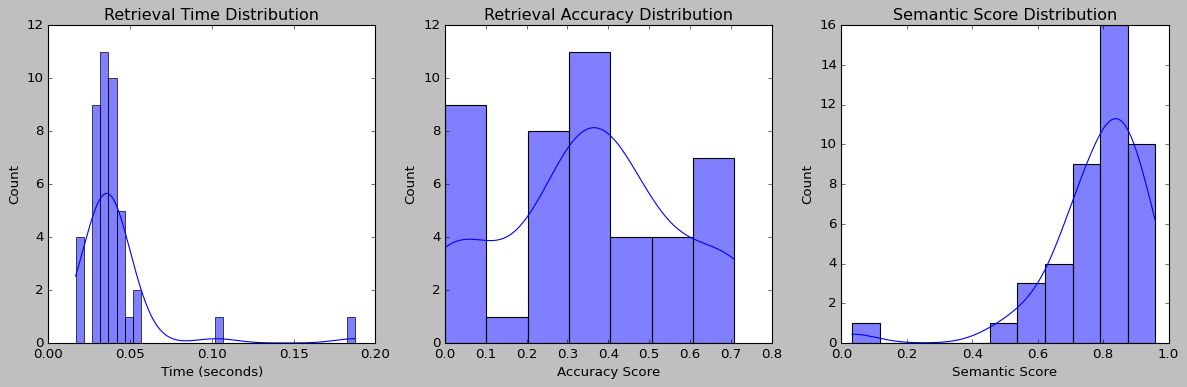

In [23]:
evaluator.plot_results()

## Using Actual Dataset to generate Evaluation Set

In [4]:
# Import necessary libraries
import os
from pathlib import Path
from typing import List, Dict
import json
from tqdm import tqdm
from datetime import datetime
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    Settings,
    PromptTemplate
)
from llama_index.core.node_parser import SentenceSplitter
from llama_index.readers.file import PDFReader, DocxReader
from llama_index.readers.file.tabular import PandasExcelReader
from llama_index.core.evaluation import generate_question_context_pairs

# Import your existing LLM loader
from llm_loader import load_llm
from llama_index.llms.openai import OpenAI
import os
from dotenv import load_dotenv
from llama_index.core import VectorStoreIndex, Settings
import time
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 

In [2]:
class RagDataset:
    def __init__(self, data):
        """Initialize with JSON data
        
        Args:
            data (dict): Dictionary containing examples with queries and contexts
        """
        self.data = data
        self.examples = self.data.get("examples", [])
    
    @property 
    def queries(self):
        """Get list of all queries"""
        return [example["query"] for example in self.examples]
    
    @property
    def reference_contexts(self):
        """Get list of reference contexts for each example"""
        # Handle both string and dict contexts
        contexts = []
        for example in self.examples:
            context = example.get("reference_contexts", [])
            # If context is dictionary, get values
            if isinstance(context[0], dict):
                contexts.append(list(context[0].values())[0])
            else:
                contexts.append(context[0])
        return contexts
    
    @property
    def reference_answers(self):
        """Get list of reference answers"""
        return [example.get("reference_answer", "") for example in self.examples]
    
    def get_example(self, idx):
        """Get complete example at index"""
        if idx >= len(self.examples):
            raise IndexError(f"Index {idx} out of range for dataset with {len(self.examples)} examples")
        return self.examples[idx]

In [13]:
# Initialize LLM
llm = load_llm()
Settings.llm = llm

Settings.embed_model = HuggingFaceEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    cache_folder="./embedding_cache"
)

# Load OpenAI API key from .env file
# load_dotenv()

# # Initialize GPT-4 for question generation
# gpt4_llm = OpenAI(
#     model="gpt-4",  # or "gpt-4" for base model
#     api_key=os.getenv("OPENAI_API_KEY"),
#     temperature=0.2
# )

llama_init_from_model: n_ctx_per_seq (3904) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

In [14]:
def load_documents(directory: str = "./Document"):
    """Load documents using LlamaIndex readers"""
    
    # Configure readers for different file types
    file_readers = {
        ".pdf": PDFReader(),
        ".docx": DocxReader(),
        ".xlsx": PandasExcelReader()
    }
    
    # Initialize SimpleDirectoryReader with custom configuration
    reader = SimpleDirectoryReader(
        input_dir=directory,
        file_extractor=file_readers,
        filename_as_id=True
    )
    
    # Load all documents
    documents = reader.load_data()
    print(f"Loaded {len(documents)} documents")
    return documents

In [15]:
documents = load_documents()

Loaded 4 documents


In [16]:
documents

[Document(id_='/Users/danielmak/Documents/local_RAG/Document/AIBots - FAQs.docx_part_0', embedding=None, metadata={'file_name': 'AIBots - FAQs.docx', 'file_path': '/Users/danielmak/Documents/local_RAG/Document/AIBots - FAQs.docx', 'file_type': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document', 'file_size': 35687, 'creation_date': '2025-03-06', 'last_modified_date': '2025-03-06'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text="What are the Data Lab's operating hours?\n\nThe MOM Data Lab is open from Tuesdays to Thursdays, 9.30 AM to 5.30 PM and is closed from 12 to 2 PM. The lab may also be closed on days when no ad

In [ ]:
def create_evaluation_dataset(
    documents,
    num_questions_per_chunk: int = 3,
    base_output_path: str = "./Document/evaluation_datasets"
):
    """Create evaluation dataset using LlamaIndex's generate_question_context_pairs"""

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = Path(base_output_path) / f"evaluation_dataset_{timestamp}.json"
    
    # Create node parser for chunking
    node_parser = SentenceSplitter(
        chunk_size=512,
        chunk_overlap=50
    )
    nodes = node_parser.get_nodes_from_documents(documents)
    print(f"Total documents: {len(documents)}")
    print(f"Total chunks: {len(nodes)}")
    print(f"Estimated questions to generate: {len(nodes) * num_questions_per_chunk}")

    # You can also see chunk distribution per document
    doc_chunks = {}
    for node in nodes:
        doc_id = node.metadata.get('file_name', 'unknown')
        doc_chunks[doc_id] = doc_chunks.get(doc_id, 0) + 1

    print("\nChunks per document:")
    for doc_id, count in doc_chunks.items():
        print(f"- {doc_id}: {count} chunks")

    # Generate question-context pairs
    print("Generating question-context pairs...")
    qc_pairs = generate_question_context_pairs(
        nodes=nodes,
        llm=Settings.llm,
        num_questions_per_chunk=num_questions_per_chunk,
    )
    
    # Format into dataset structure
    dataset = {
        "examples": [
            {
                "query": pair[0],
                "reference_contexts": [pair[1]],  # Keeping original context handling
                "reference_answer": pair[2] if len(pair) > 2 else "",
                "query_by": {
                    "model_name": "llama-2",
                    "type": "ai",
                    "timestamp": timestamp
                },
                "metadata": {
                    "source": getattr(pair[1], 'metadata', {}).get('file_name', ''),
                    "doc_id": getattr(pair[1], 'node_id', '')
                }
            }
            for pair in qc_pairs
        ],
        "dataset_info": {
            "total_documents": len(documents),
            "total_chunks": len(nodes),
            "questions_per_chunk": num_questions_per_chunk,
            "creation_timestamp": timestamp,
            "chunk_distribution": doc_chunks
        }
    }
    
    # Save dataset with timestamp
    output_path.parent.mkdir(parents=True, exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump(dataset, f, indent=2)
    
    print(f"Created dataset with {len(dataset['examples'])} examples")
    print(f"Saved to: {output_path}")
    return dataset

In [8]:
# def create_evaluation_dataset(
#     documents,
#     num_questions_per_chunk: int = 3,
#     base_output_path: str = "./Document/evaluation_datasets"
# ):
#     """Create evaluation dataset with complete reference information"""
    
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     output_path = Path(base_output_path) / f"evaluation_dataset_{timestamp}.json"
    
#     # Create node parser for chunking
#     node_parser = SentenceSplitter(
#         chunk_size=512,
#         chunk_overlap=50
#     )
    
#     nodes = node_parser.get_nodes_from_documents(documents)
    
#     # Generate question-context pairs
#     print("Generating question-context pairs...")
#     qc_pairs = generate_question_context_pairs(
#         nodes=nodes,
#         llm=Settings.llm,
#         num_questions_per_chunk=num_questions_per_chunk
#     )
    
#     # Format into dataset structure
#     dataset = {
#         "examples": [
#             {
#                 "query": pair[0],  # Question
#                 "reference_contexts": [str(pair[1])],  # Context
#                 "reference_answer": "",  # Will be generated during evaluation
#                 "query_by": {
#                     "model_name": "llama-2",
#                     "type": "ai"
#                 },
#                 "metadata": {
#                     "source": getattr(pair[1], 'metadata', {}).get('file_name', ''),
#                     "doc_id": getattr(pair[1], 'node_id', ''),
#                     "timestamp": timestamp
#                 }
#             }
#             for pair in qc_pairs
#         ]
#     }
    
#     # Save dataset
#     output_path.parent.mkdir(parents=True, exist_ok=True)
#     with open(output_path, 'w') as f:
#         json.dump(dataset, f, indent=2)
        
#     print(f"\nCreated dataset with {len(dataset['examples'])} examples")
#     print(f"Saved to: {output_path}")
    
#     return dataset

In [9]:
# Usage example
documents = load_documents()
eval_dataset = create_evaluation_dataset(
    documents=documents,
    num_questions_per_chunk=3,
    base_output_path="./Document/evaluation_datasets"
)

Loaded 4 documents
Total documents: 4
Total chunks: 14
Estimated questions to generate: 42

Chunks per document:
- AIBots - FAQs.docx: 5 chunks
- Aibot - Datalab.docx: 5 chunks
- Synthetic Data Dictionary.xlsx: 1 chunks
- Synthetic Standard Operating Procedures for Research Data Laboratory.docx: 3 chunks
Generating question-context pairs...


100%|██████████| 14/14 [01:39<00:00,  7.07s/it]

Created dataset with 4 examples
Saved to: Document/evaluation_datasets/evaluation_dataset_20250318_141432.json


In [18]:

custom_prompt = PromptTemplate(
    """\
Rewrite the user's follow-up question as a standalone question.

1. Include all relevant past context.
2. Keep it natural and grammatically correct.
3. If already standalone, return it unchanged.

<Chat History>
{chat_history}

<User's Follow-Up Question>
{question}

<Rewritten Standalone Question>
"""
)


response_prompt = PromptTemplate(
    """\
You are an AI assistant providing structured responses.

### **Instructions:**
- Answer clearly and concisely.
- Summarize retrieved context to avoid duplication.
- Summarize the key facts efficiently.
- If the context lacks enough details, say: "I don’t have enough information."
- Format responses in natural sentences.

<Retrieved Context>
{context}

<User's Query>
{question}

### **AI Response:**
"""
)

# Create index directly from documents
index = VectorStoreIndex.from_documents(
    documents,
    show_progress=True
)

# Create query engine from this index
query_engine = index.as_query_engine(
    response_mode="compact",
    response_prompt=response_prompt,
    similarity_top_k=3,
    max_tokens=300,
    streaming=False
)

Parsing nodes:   0%|          | 0/4 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/8 [00:00<?, ?it/s]

In [33]:
def run_evaluation(
    dataset_path: str,
    documents,
    response_prompt: PromptTemplate,
    results_path: Path = None
) -> tuple:
    """Run evaluation and optionally save results"""
    # Load dataset
    with open(dataset_path, 'r') as f:
        eval_dataset = json.load(f)
    
    # Setup RAG components
    rag_dataset = RagDataset(eval_dataset)
    index = VectorStoreIndex.from_documents(documents, show_progress=True)
    query_engine = index.as_query_engine(
        response_mode="compact",
        response_prompt=response_prompt,
        similarity_top_k=3,
        max_tokens=300,
        streaming=False
    )
    
    # Run evaluation
    evaluator = EvaluationMetrics(rag_dataset)
    evaluator.evaluate_all_queries(query_engine, llm=Settings.llm)
    
    # Save results if path provided
    if results_path:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        results = {
            "metrics": evaluator.get_summary_metrics(),
            "dataset_path": str(dataset_path),
            "timestamp": timestamp
        }
        
        output_path = results_path / f"eval_results_{timestamp}.json"
        with open(output_path, 'w') as f:
            json.dump(results, f, indent=2)
    
    return evaluator, evaluator.get_summary_metrics()

In [34]:
# Run evaluation
evaluator, metrics = run_evaluation(
    dataset_path="./Document/evaluation_datasets/evaluation_dataset_20250318_141432.json",
    documents=documents,
    response_prompt=response_prompt,
    results_path=None
)

Parsing nodes:   0%|          | 0/4 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating 4 queries...


100%|██████████| 4/4 [01:32<00:00, 23.05s/it]


In [ ]:
# Show results
evaluator.plot_results()

Evaluating 4 queries...


100%|██████████| 4/4 [01:30<00:00, 22.56s/it]
/opt/miniconda3/envs/local_RAG/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/local_RAG/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


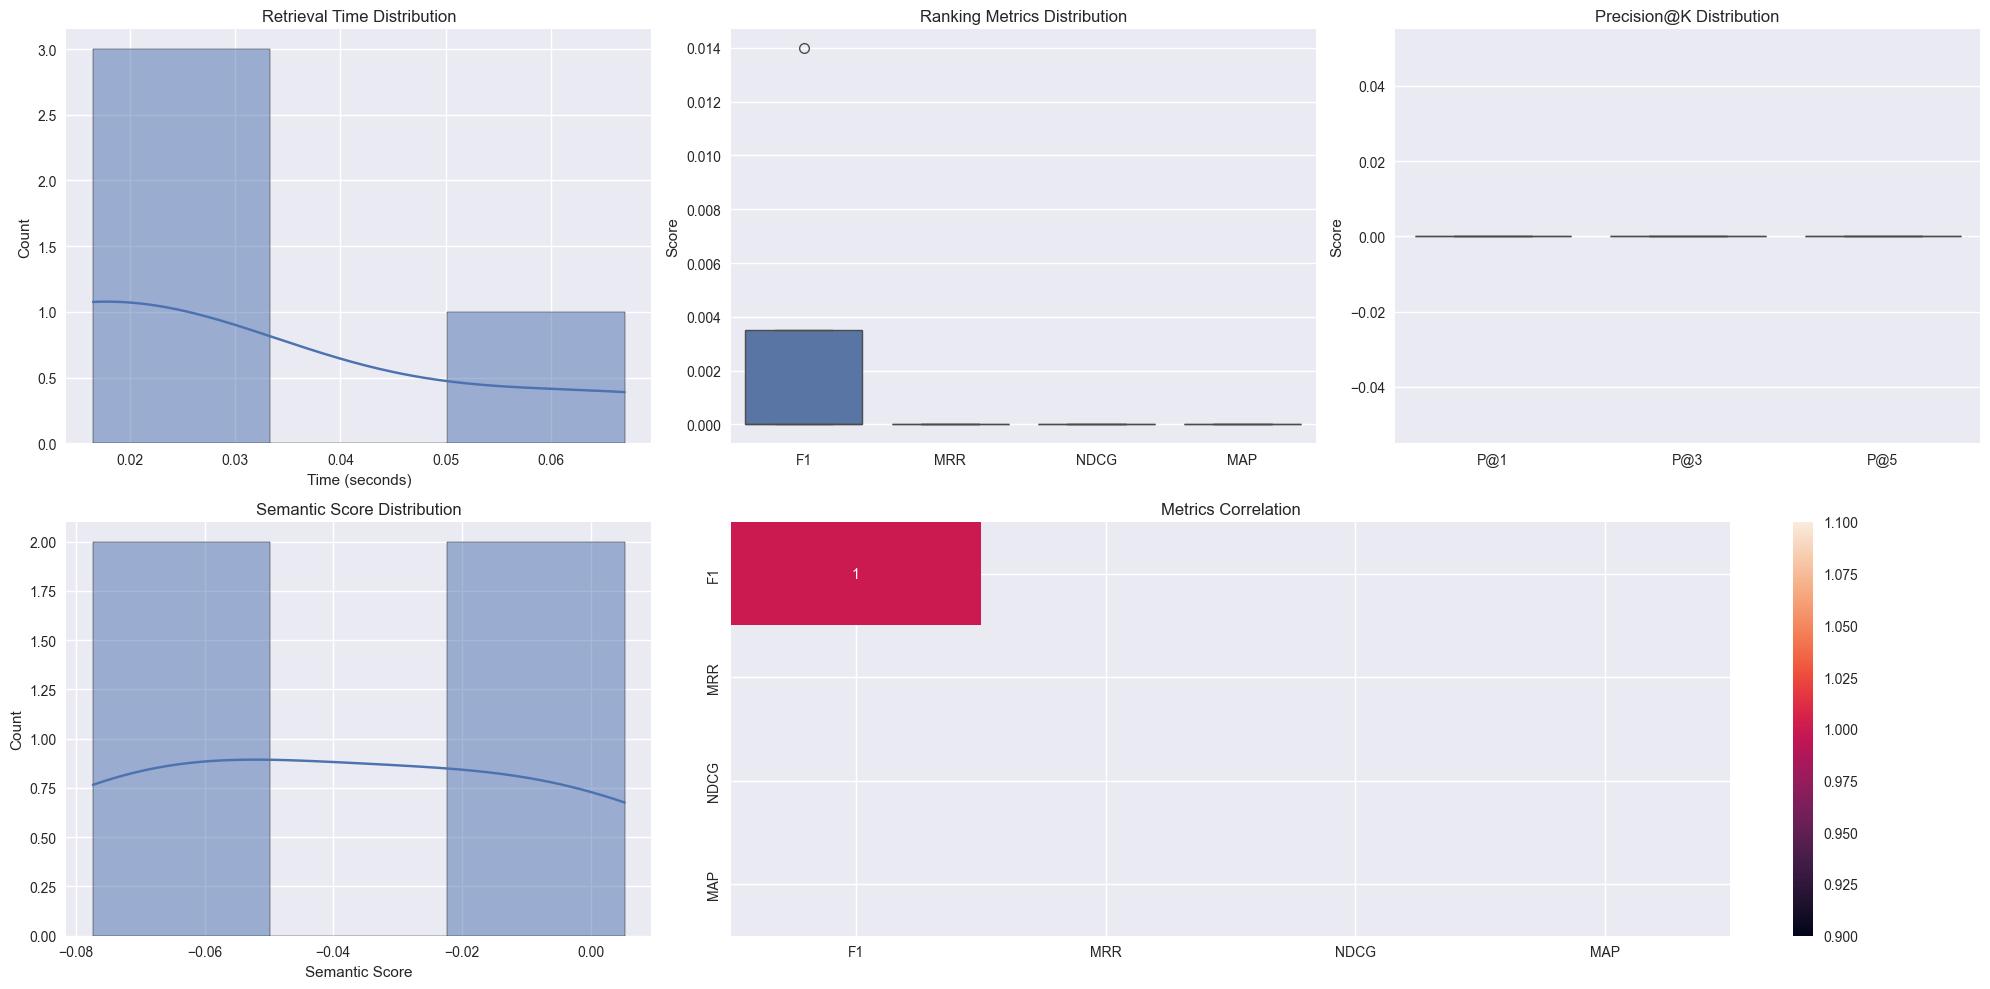

In [ ]:
# Load evaluation dataset from JSON
with open("./Document/evaluation_datasets/evaluation_dataset_20250318_141432.json", "r") as f:
    eval_dataset = json.load(f)

# Create RAG dataset instance
rag_dataset = RagDataset(eval_dataset)
# Initialize evaluation metrics
evaluator = EvaluationMetrics(rag_dataset)
# Keep your existing query engine for answering questions
query_engine = index.as_query_engine(
    response_mode="compact",
    response_prompt=response_prompt,
    similarity_top_k=3,
    max_tokens=300,
    streaming=False
)

# Run evaluation
evaluator.evaluate_all_queries(query_engine, llm=llm)
evaluator.get_summary_metrics()
evaluator.plot_results()

In [5]:

def setup_evaluation_directories(base_path: str = "./Document/evaluation_datasets") -> dict:
    """Create and return evaluation directory structure"""
    paths = {
        "base": Path(base_path),
        "llm": Path(base_path) / "llm_generated",
        "manual": Path(base_path) / "manual",
        "results": Path(base_path) / "results"
    }
    
    for path in paths.values():
        path.mkdir(parents=True, exist_ok=True)
    
    return paths

paths = setup_evaluation_directories()

In [6]:
## This section will be used to load the manual QnA questions later

paths

{'base': PosixPath('Document/evaluation_datasets'),
 'llm': PosixPath('Document/evaluation_datasets/llm_generated'),
 'manual': PosixPath('Document/evaluation_datasets/manual'),
 'results': PosixPath('Document/evaluation_datasets/results')}